One can start from this notebook, when working with Raman measurements. Just change the data path below to point to your exported Raman measurements in text files.
The Raman measurements need to be exported from Witec Project as *table* and make sure to have the Raman shift dimensions in cm$^{-1}$.

For in depth documentation of `ramantools`, check the documentation on [github.io](https://zrbyte.github.io/ramantools/).

To use this notebook on your PC, the data needs to be loaded as described below, in section [Loading on PC](#Loading-on-PC).

# Table of contents
- [Loading a Raman map](#Loading-a-Raman-map)
- [Working with ramantools](#Working-with-ramantools)
- [Working with data](#Working-with-data)
    - [Calibration](#Calibration)
    - [Subtracting background](#subtracting-background)
    - [Normalizing spectra](#normalizing-spectra)
    - [Curve fitting](#curve-fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ramantools as rt
import glob, sys
import pylab as pl
import numpy as np
import xarray as xr

In [3]:
%matplotlib inline

# Loading a Raman map

For this we need to load the map, exported as *table* from *Witec Project* or *Witec Control*, as well as the text file next to the map. This text file is used to read the metadata of the Raman measurement.

## Loading on PC

<mark>You do not need to run this section when working in *binder*.</mark>

**Skip to [Loading test data from a URL](#Loading-test-data-from-a-URL)**.

In [4]:
data_path = r'C:\Users\zrbyt\OneDrive - energia.mta.hu\Documents\work_MFA\ABC\G peak anomaly\Raman measurements'
data_path += '\\'
sys.path.append(data_path)

Need to add `r` in front of the file path to treat it as a *raw string*, meaning that `\` is treated as a character.

Using `glob` to read the contents to the data folder above. The use of `glob` helps with searching for files according to patterns. See below, where we identify the map called: *ABC_36* and load its contents, including the text file containing the metadata.

In [ ]:
# list all the files in the data folder
glob.glob(data_path + '*')

In [6]:
map_path = glob.glob(data_path + '*ABC_36*' + '*Data*')[0]
info_path = glob.glob(data_path + '*ABC_36*' + '*Information*')[0]

The above is something you would do on your PC. In this online notebook, we will load the data from a URL.

## Loading test data from a URL

For use only in this tutorial.

In [7]:
import urllib

In [16]:
# link to datafile
datalink = r'https://public.ek-cer.hu/~nemes/testdata/FLG36.MK_FLG_ABC_36--Spectrum--001--Spec.Data_1.txt'
# link to infofile
infolink = r'https://public.ek-cer.hu/~nemes/testdata/FLG36.MK_FLG_ABC_36--Spectrum--001--Information.txt'

In [17]:
f = urllib.request.urlopen(datalink)
myfile = f.read().decode('latin1').replace('\n', ' ')
with open('data.txt', mode = 'w', encoding = 'latin1') as f:
    f.write(myfile)

In [18]:
f = urllib.request.urlopen(infolink)
myfile = f.read().decode('latin1').replace('\n', ' ')
with open('info.txt', mode = 'w', encoding = 'latin1') as f:
    f.write(myfile)

In [4]:
map_path = 'data.txt'
info_path = 'info.txt'

# Working with ramantools

Let's load the data from the text files. We can do this by passing the path of the map file and the info file to the `ramanmap` class. Let's call it `m`.
<a id='loading_map'></a>

In [19]:
m = rt.ramanmap(map_path, info_path)

`rt.ramanmap(map_path, info_path)` returns a `ramanmap` object, which among other data, contains as variables:
- the raw imported, Raman measurements are stored in: `m.map`
- all the metadata in: `m.metadata`. The `m.print_metadata()` function, prints the contents of the info file.
- The Raman shift of the measurement is stored in `m.ramanshift`

In addition to the above, the `ramanmap` object, called `m` in this example has the following variables, mostly containing the measurement metadata:

In [8]:
list(m.__dict__)

['filename',
 'mask',
 'metadata',
 'mapname',
 'pixel_x',
 'pixel_y',
 'size_x',
 'size_y',
 'date',
 'time',
 'samplename',
 'laser',
 'itime',
 'grating',
 'objname',
 'objmagn',
 'positioner_x',
 'positioner_y',
 'ramanshift',
 'map',
 'metadata_datafile',
 'wipfilename',
 'mapxr']

The Raman shift is stored in the variable: `m.ramanshift`

In [ ]:
m.ramanshift

1600

## The Raman map in `xarray`

The data is also loaded into an `xarray` container. This can be found in the `mapxr` variable of the `ramanmap` object.

In [9]:
# let's just call this `xr` for ease of use.
xrm = m.mapxr

These are the metadata loaded also into the xarray. For example this makes plotting easier by including the relevant metadata as axis labels, etc.

In [10]:
xrm.attrs

{'comments': 'raw data loaded \n',
 'wipfile name': 'C:\\Users\\zrbyt\\OneDrive - energia.mta.hu\\Documents\\work_MFA\\ABC\\G peak anomaly\\Raman measurements\\FLG36.wip',
 'units': 'au',
 'long_name': 'Raman intensity',
 'sample name': 'MK_FLG_ABC_36',
 'laser excitation': '487.986 nm',
 'time of measurement': '14:16:33',
 'date of measurement': '2023. május 25., csütörtök',
 'integration time': '0.5 s',
 'map width': '97.0 um',
 'map height': '77.0 um',
 'sample positioner X': -1470.0,
 'sample positioner Y': 1170.6,
 'objective name': 'Zeiss EC Epiplan-Neofluar Dic 50x / 0.8',
 'objective magnification': '50.0x',
 'grating': 'G1: 600 g/mm BLZ=500nm'}

In [11]:
print(xrm.attrs['comments'])

raw data loaded 



In [12]:
xrm.attrs['map width'], xrm.attrs['map height']

('97.0 um', '77.0 um')

We can see that the map is 77x97 $\mu m$ in size. Let's select a spectrum from somewhere in the middle and plot it.

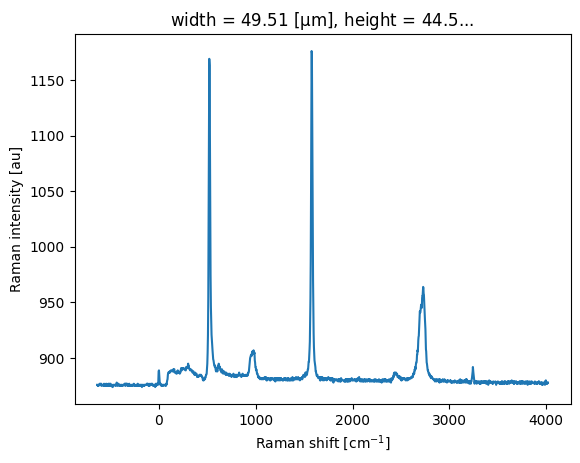

In [13]:
_ = xrm.sel(width = 50, height = 45, method = 'nearest').plot()

Let's zoom in on the G peak area, by slicing, ie. giving a range of values to plot, using the `slice()` function. For this we need to use another `sel()` function.
One can pass options to the `plot()` function, similarly to a normal matplotlib plot. In this case, I've specified the marker and the color of the plot.

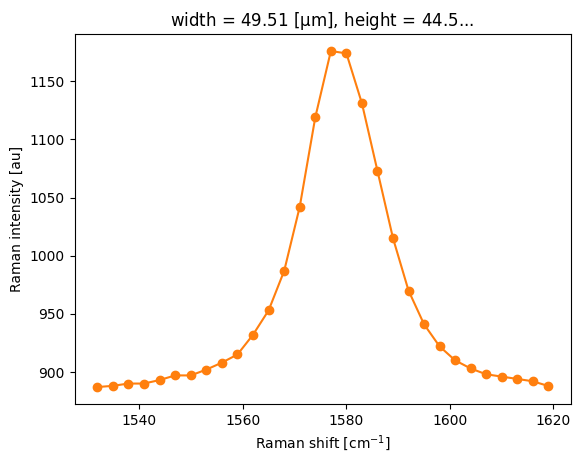

In [14]:
ss = xrm.sel(width = 50, height = 45, method = 'nearest')
ss.sel(ramanshift = slice(1530, 1620)).plot(marker = 'o', color = 'tab:orange')

Ok. Now let's plot the intensity of the G peak over the whole map.

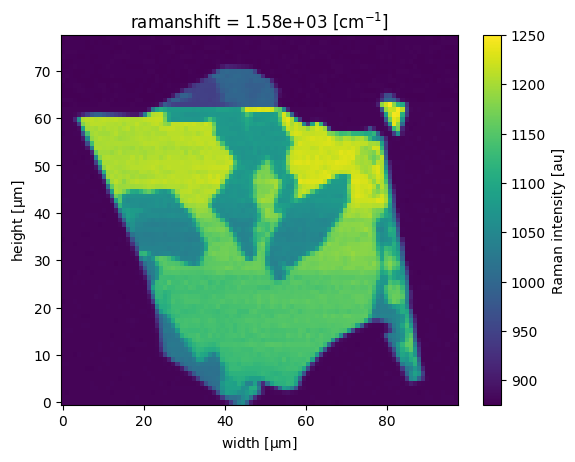

In [15]:
xrm.sel(ramanshift = 1580, method = 'nearest').plot()

`ramantools` has a built in function for maps, called `plotspec()`, which can be used to quickly plot the position of a single spectrum on the map. This takes the arguments for the coordinates at which we can plot it. Furthermore, it takes a Raman shift as the last argument, at which to plot the Raman intensity in the map.

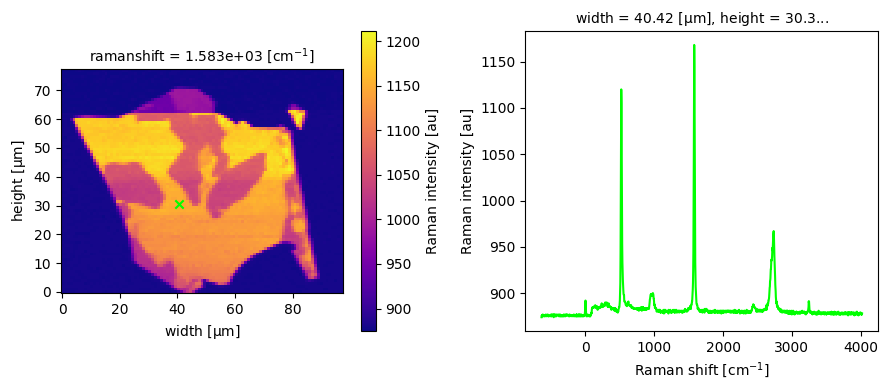

In [9]:
m.plotspec(40, 30, 1583)

For more complicated plots, you can just do whatever you need by hand.

## Saving the `xarray` DataArray to netcdf format

In [17]:
xrm.to_netcdf(data_path + 'xrm.nc')

In [18]:
xrm2 = xr.open_dataarray(data_path + 'xrm.nc')

In [19]:
xrm2

<xarray.DataArray (ramanshift: 1600, height: 77, width: 97)>
[11950400 values with dtype=float64]
Coordinates:
  * ramanshift  (ramanshift) float64 -639.5 -635.7 ... 4.017e+03 4.019e+03
  * width       (width) float64 0.0 1.01 2.021 3.031 ... 93.97 94.98 95.99 97.0
  * height      (height) float64 0.0 1.013 2.026 3.039 ... 74.97 75.99 77.0
Attributes: (12/16)
    comments:                 raw data loaded \n
    wipfile name:             C:\Users\zrbyt\OneDrive - energia.mta.hu\Docume...
    units:                    au
    long_name:                Raman intensity
    sample name:              MK_FLG_ABC_36
    laser excitation:         487.986 nm
    ...                       ...
    map height:               77.0 um
    sample positioner X:      -1470.0
    sample positioner Y:      1170.6
    objective name:           Zeiss EC Epiplan-Neofluar Dic 50x / 0.8
    objective magnification:  50.0x
    grating:                  G1: 600 g/mm BLZ=500nm

## Loading single Raman spectra

For this we will use the test data on Github, in the folder: 'test data'

In [10]:
data_path_ss = 'test data/FLG36.MK_FLG_ABC_36--Spectrum--001--Spec.Data 1.txt'
info_path_ss = 'test data/FLG36.MK_FLG_ABC_36--Spectrum--001--Information.txt'

In [11]:
single_s = rt.singlespec(data_path_ss, info_path_ss)

For single spectra, we also get an `xarray` object, called `ssxr`. 

We can plot this similarly to the map. This has only one coordinate.

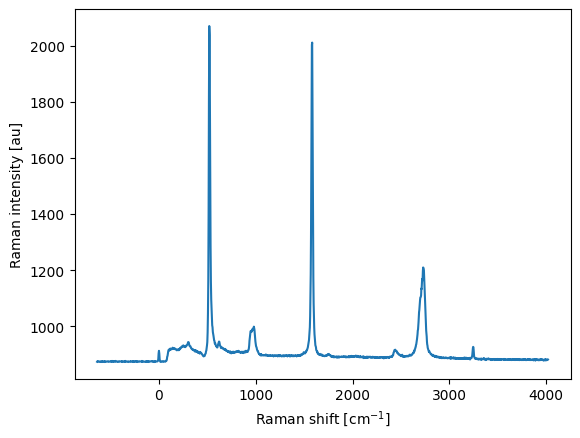

In [12]:
single_s_plot = single_s.ssxr.plot()

In [95]:
single_s.print_metadata()

Comments of the `xarray` DataArray 

raw data loaded 

------------------
MK_FLG_ABC_36--Spectrum--001

General:
System ID:	100-1100-758
Start Time:	13:58:55
Start Date:	2023. május 25., csütörtök
Duration:	0h 0m 6s
User Name:	Witec
Sample Name:	MK_FLG_ABC_36
Configuration:	Raman CCD1

UHTS300M:
Excitation Wavelength [nm]:	487.986
Grating:	G1: 600 g/mm BLZ=500nm
Center Wavelength [nm]:	540.752
Spectral Center [rel. 1/cm]:	1999.637

DU970_BV:
Width [Pixels]:	1600
Height [Pixels]:	200
Temperature [°C]:	-59
Cycle Time [s]:	2.99996
Camera Serial Nr.:	13899
AD Converters:	AD1 (16Bit)
Output Amplifier:	EMCCD Gain
Vertical Shift Speed [µs]:	[4.95]
Horizontal Shift Speed [MHz]:	0.05
Preamplifier Gain:	1
EMCCD Gain:	0
ReadMode:	Full Vertical Binning

Number Of Accumulations:	1
Integration Time [s]:	3.00000

Objective:
Objective Name:	Zeiss EC Epiplan-Neofluar Dic 100x / 0.9
Objective Magnification:	100.0

Sample Location (global position):
Position X [µm]:	-1466.300
Position Y [µm]:	1170.600
Po

# Working with data

## Calibration

In [13]:
print(single_s.ssxr.attrs['comments'])

raw data loaded 



We can calibrate, by just specifying the expected position of the peak to be used for calibration. `singlespec.calibrate()` takes one argument: the expected peak position. In this case it's the Si first order peak at 520.5 cm$^{-1}$. The method will search for a peak in this vicinity and fit a Lorenztian to this and return a new `singlespec` instance, with the ramanshift calibrated.

The method also takes all possible optional arguments for `peakfit()`. In the example below we use the toplot keyword to show the result of the fitting to the Si peak.

Values of starting parameters: 
 {'x0': 520.5, 'ampl': 10, 'width': 15, 'offset': 900} 

Values of fitted parameters:

x0 : 521.74
ampl : 1240.66
width : 14.65
offset : 903.43


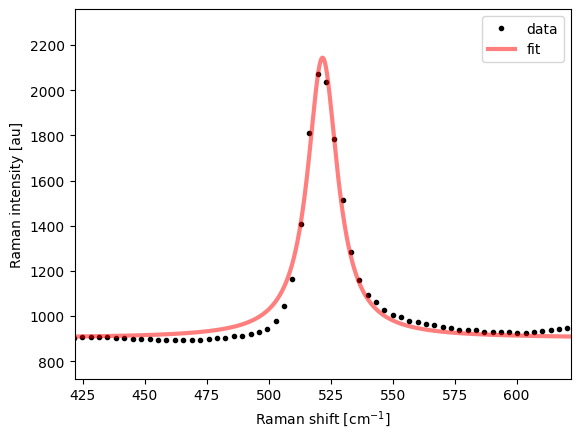

In [14]:
single_s_calib = single_s.calibrate(520.5, toplot = True)

In [15]:
# comments are updated by the calibration factor
print(single_s_calib.ssxr.attrs['comments'])

raw data loaded 
calibrated Raman shift by adding -1.24 cm^-1 to the raw ramanshift



Let's plot the result and the original data.

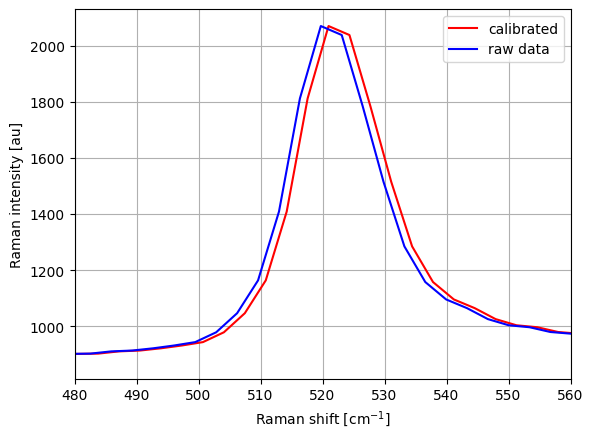

In [13]:
single_s_calib.ssxr.plot(color = 'r', label = 'calibrated')
single_s.ssxr.plot(color = 'b', label = 'raw data')
pl.xlim([480, 560])
pl.grid()
pl.legend()

We can also specify a calibration factor, using the optional keyword argument: `calibfactor`. In this case the `peakshift` argument is disregarded.

raw data loaded 
Calibrated Raman shift by adding -5.00 cm^-1 to the raw ramanshift


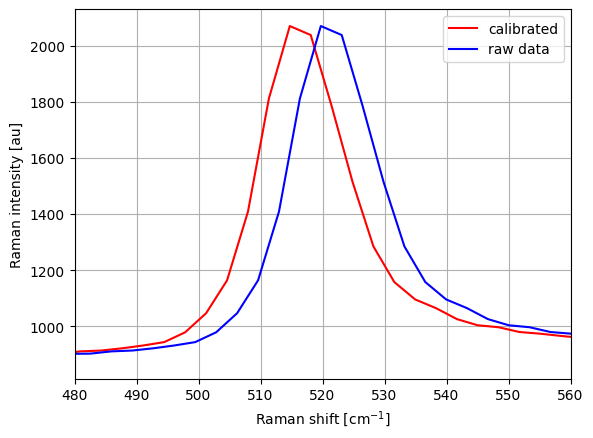

In [14]:
single_s_calib2 = single_s.calibrate(520.5, calibfactor = -5)
print(single_s_calib2.ssxr.attrs['comments'])
single_s_calib2.ssxr.plot(color = 'r', label = 'calibrated')
single_s.ssxr.plot(color = 'b', label = 'raw data')
pl.xlim([480, 560])
pl.grid()
pl.legend()

For maps it is similar.

In [15]:
print(m.mapxr.attrs['comments'])

raw data loaded 



In [23]:
m_calib = m.calibrate(520)

In [24]:
print(m_calib.mapxr.attrs['comments'])

raw data loaded 
Calibrated Raman shift by adding 1.23 cm^-1 to the raw ramanshift


Let's check a spectrum from the map, to see the change.

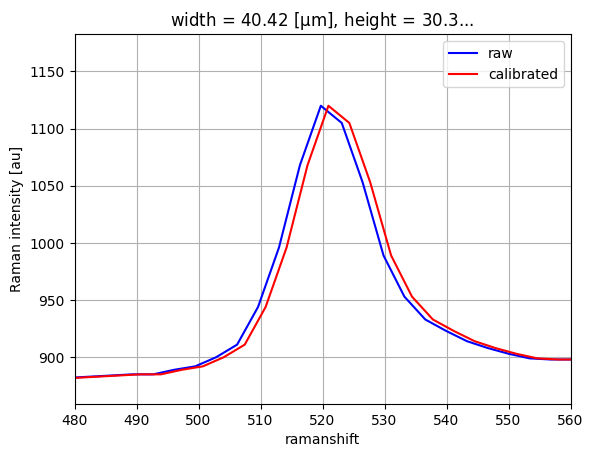

In [25]:
m.mapxr[:, 30, 40].plot(color = 'b', label = 'raw')
m_calib.mapxr[:, 30, 40].plot(color = 'r', label = 'calibrated')
pl.xlim([480, 560])
pl.grid()
pl.legend()

## Subtracting background

First thing we do is we can subtract the background from the spectra. One can easily do arthmetic with an `xarray` DataArray. Let's just subtract 800 from the spectra in the map.

In [24]:
single_bgsub = single_s.ssxr - 850

As you can see this is just another `xarray` object, with the Raman intensity values being smaller by 800.

In [25]:
single_bgsub

<xarray.DataArray (ramanshift: 1600)>
array([24., 26., 25., ..., 31., 31., 32.])
Coordinates:
  * ramanshift  (ramanshift) float64 -639.5 -635.7 ... 4.017e+03 4.019e+03

The attributes from the old `xarray` object are not carried over to the new one. One reason for this is that units are generally stored in attributes and most of the time arithmetic involves changes in units.
In `ramantools`, if a method or function generates a new `xarray` instance, we try to make sure that the attributes stay up to date and carry over any changes in units.

### Background subtraction by fitting to the baseline

#### Single spectra

Let's try this for a single spectrum. This can be done by the `remove_bg()` method of the `singlespec` class.
Usually this can be run without any arguments. In this case the method tries to find the peaks and disregard their surroundings. More details in the [documentation](https://zrbyte.github.io/ramantools/index.html).

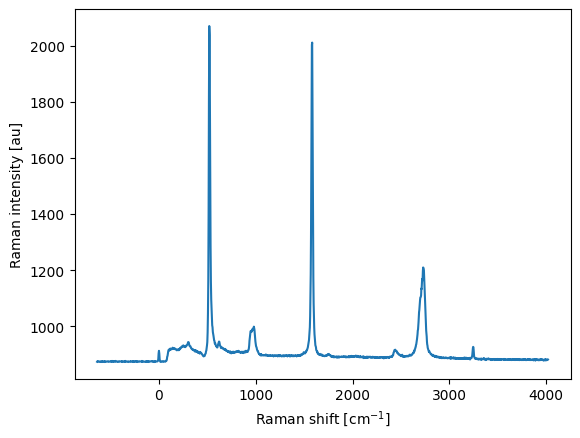

In [26]:
# This is our raw data.
single_s.ssxr.plot()

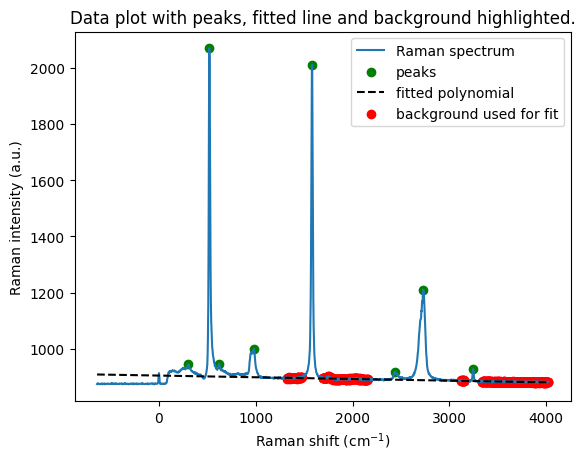

In [27]:
# Let's remove the background, with the toplot = True option to see what `removebg()` does
new_single_s, coeff, covar = single_s.remove_bg(toplot = True)

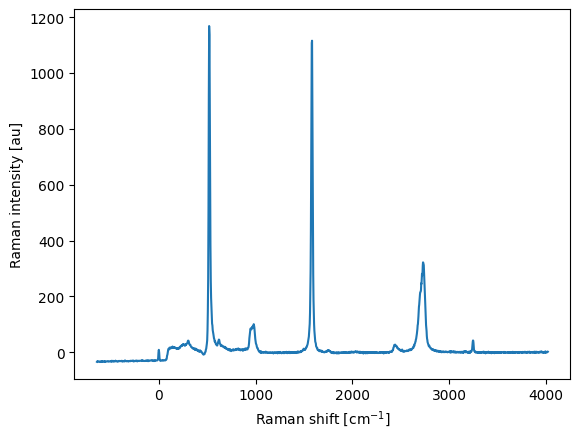

In [281]:
new_single_s.ssxr.plot()

Many optional arguments can be passed to `remove_bg()`, the list can be found [here](https://zrbyte.github.io/ramantools/ramantools.html#ramantools.bgsubtract).

We can see that `remove_bg()` has found the peaks marked by green dots and disregarded the area around them. The fitting parameters can be found in the 'comments' attribute of the `xarray` instance.

In [28]:
print(new_single_s.ssxr.attrs['comments'])

raw data loaded 
background subtracted, with parameters: {'polyorder': 1, 'hmin': 50, 'hmax': 10000, 'wmin': 4, 'wmax': 60, 'prom': 10, 'exclusion_factor': 6, 'peak_pos': None}



This 'comments' field also acts as a log of what happened to the data, as we work with the `ramantools` methods and functions that act on `xarray` objects.

Let's try to change the polynomial order to 2 and give the peaks to be fit by hand:

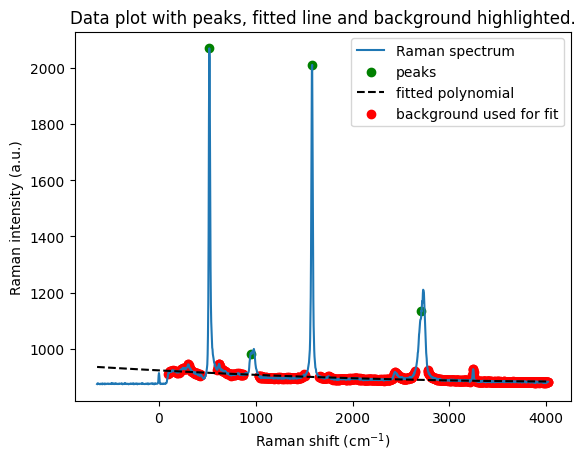

In [29]:
new_single_s, coeff, covar = single_s.remove_bg(
    toplot = True,
    polyorder = 2,
    peak_pos = [520, 950, 1583, 2710])
# The position of the peaks to be removed is given in a list

We can see that not all of the peaks, especially the 2D peak is not removed entirely, we can correct this be either increasing the `wmin` parameter, which is the minimum width of the peaks considered by the method, or by increasing the `exclusion_factor` parameter. This last parameter means: how much of the FWHM of the peak (defined by `wmin`) is removed.

Let's change `wmin` to 12.

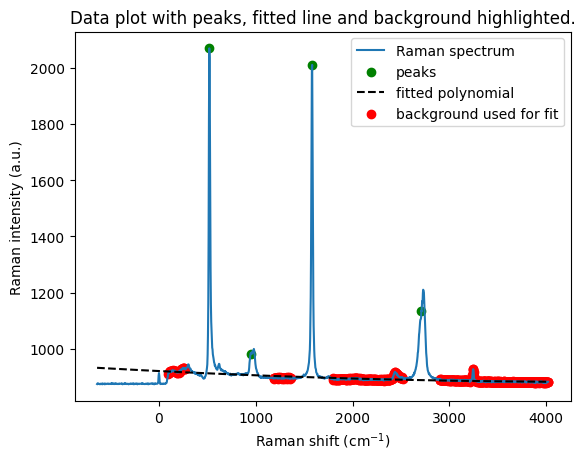

In [30]:
new_single_s, covar, covar = single_s.remove_bg(
    toplot = True,
    polyorder = 2,
    peak_pos = [520, 950, 1583, 2710],
    wmin = 12)

This is much better, giving us a nice second order fit.

Final tweaks: If we don't want the area around 0 cm$^{-1}$, we can just "add a peak there". Let's change back to linear fit.

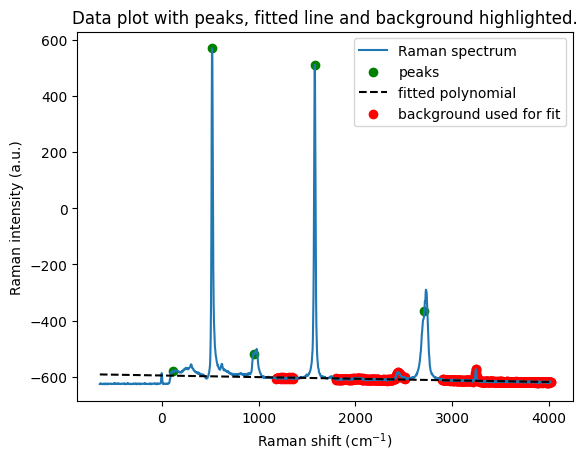

In [189]:
new_single_s, coeff, covar = single_s.remove_bg(
    toplot = True,
    polyorder = 1,
    peak_pos = [120, 520, 950, 1583, 2710],
    wmin = 12)

The fit mask used is also returned as a variable of the [`singlespec`](https://zrbyte.github.io/ramantools/ramantools.html#ramantools.singlespec) instance, called `single_s` in this example.

In [32]:
new_single_s.mask

array([False, False, False, ...,  True,  True,  True])

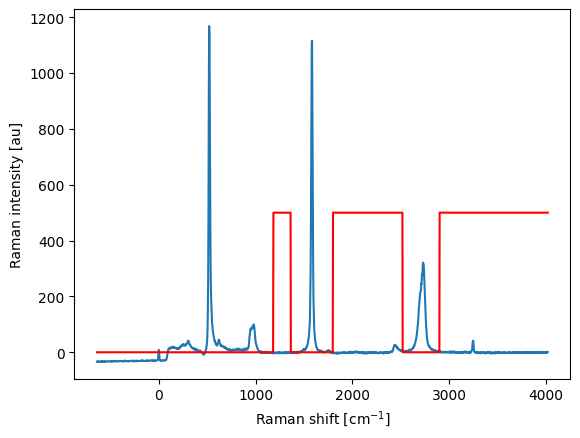

In [33]:
# Let's plot the mask
new_single_s.ssxr.plot()
pl.plot(new_single_s.ssxr.ramanshift, new_single_s.mask*500, 'r')

The returned `xarray` instance has the same attributes as the original, with the "comments" field appended.

In [34]:
new_single_s.ssxr.attrs

{'comments': "raw data loaded \nbackground subtracted, with parameters: {'polyorder': 1, 'hmin': 50, 'hmax': 10000, 'wmin': 12, 'wmax': 60, 'prom': 10, 'exclusion_factor': 6, 'peak_pos': [120, 520, 950, 1583, 2710]}\n",
 'wipfile name': 'C:\\Users\\zrbyt\\OneDrive - energia.mta.hu\\Documents\\work_MFA\\ABC\\G peak anomaly\\Raman measurements\\FLG36.wip',
 'units': 'au',
 'long_name': 'Raman intensity',
 'sample name': 'MK_FLG_ABC_36',
 'laser excitation': '487.986 nm',
 'time of measurement': '13:58:55',
 'date of measurement': '2023. május 25., csütörtök',
 'integration time': '3.0 s',
 'sample positioner X': -1466.3,
 'sample positioner Y': 1170.6,
 'sample positioner Z': 0.0,
 'objective name': 'Zeiss EC Epiplan-Neofluar Dic 100x / 0.9',
 'objective magnification': '100.0x',
 'grating': 'G1: 600 g/mm BLZ=500nm'}

In [43]:
print(new_single_s.ssxr.attrs['comments'])

raw data loaded 
background subtracted, with parameters: {'polyorder': 1, 'hmin': 50, 'hmax': 10000, 'wmin': 12, 'wmax': 60, 'prom': 10, 'exclusion_factor': 6, 'peak_pos': [120, 520, 950, 1583, 2710]}



The ammented "comments" acts as a log of the parameters used for fitting.

Let's plot the result:

#### Background fitting for maps

Let's try the simplest approach. Just calling the `remove_bg()` method of the `ramanmap` instance called `m`. This is the map we loaded at the beginning of the tutorial, here: [Loading a Raman map](#Loading-a-Raman-map).

In [97]:
new_m, coeff, covar = m.remove_bg()

In [44]:
print(new_m.mapxr.attrs['comments'])

raw data loaded 
background subtracted - mode == const, background fit: middle spectrum 



In [49]:
new_m.pixel_x, new_m.pixel_y

(97, 77)

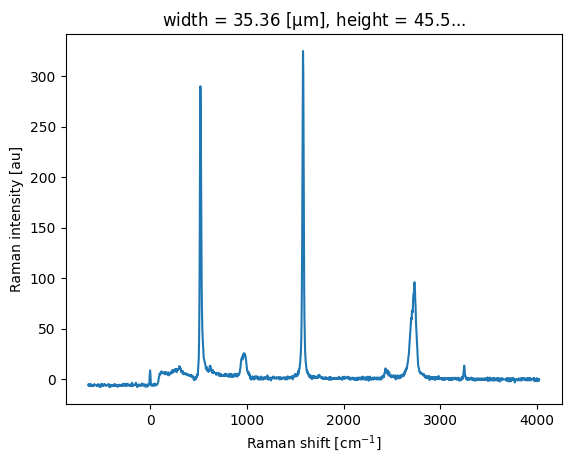

In [50]:
# selecting a spectrum from the map to plot
new_m.mapxr[:, 45, 35].plot()

Looks good. Let's look at some more options.

Using it without options, fits a background to the middle spectrum of the map. This simplest approach, uses the `bgsubtract()` function, with no options, meaning automatic detection of peaks. The method `ramanmap.remove_bg()` accepts the same parameters as the `singlespec.remove_bg()`, but has additional options. For a list of parameters see the documentation of [`bgsubtract()`](https://zrbyte.github.io/ramantools/ramantools.html#ramantools.bgsubtract) and [remove_bg](https://zrbyte.github.io/ramantools/ramantools.html#ramantools.ramanmap.remove_bg).

If the automatic background subtraction doesn't produce the desired outcome, one can tweak the fitting procedure. A good idea would be to take the most "problematic" spectrum from the map and fit a background to that by hand, either using the function `bgsubtract()`, which acts on `numpy` arrays or `singlespec.remove_bg()`, which acts on `xarray` instances.

Let's try this by selecting one of the spectra from the map. We can then tune the fitting parameters to suit our needs. After a satisfactory fit parameter has been found, we can pass that to the `ramanmap.remove_bg()`. Most importantly, we can pass a `fitmask` supplied by all background fitting functions. Let's see an example of this.

In [52]:
# selecting a spectrum
spec = m.mapxr.sel(width = 30, height = 40, method = 'nearest')

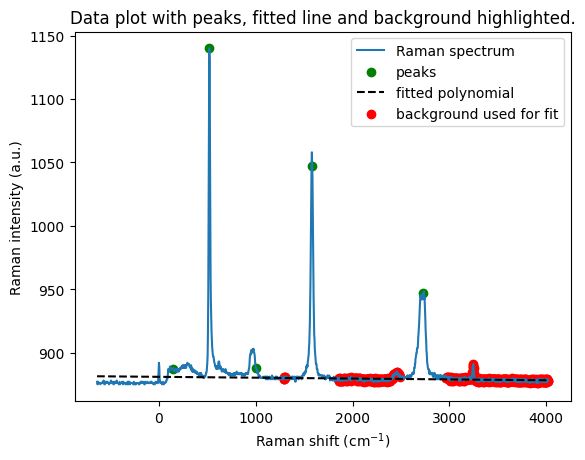

In [56]:
# let's try some fit parameters with this
y_data_nobg, bg_values, coeff, params_used_at_run, mask, covar = rt.bgsubtract(spec.coords['ramanshift'].data, spec.data, toplot = True, peak_pos = [140, 520, 1000, 1583, 2730], wmin = 15)

The above `bgsubtract()` has returned among other parameters, the mask used to fit the data: `mask`. We can pass this to the `fitmask` optional parameter of `ramanmap.remove_bg()`. In this case the peak search will be skipped and a polynomial fit will be applied based on the data covered by the mask. Default polynomial fit is of order 1.

In [57]:
mask

array([False, False, False, ...,  True,  True,  True])

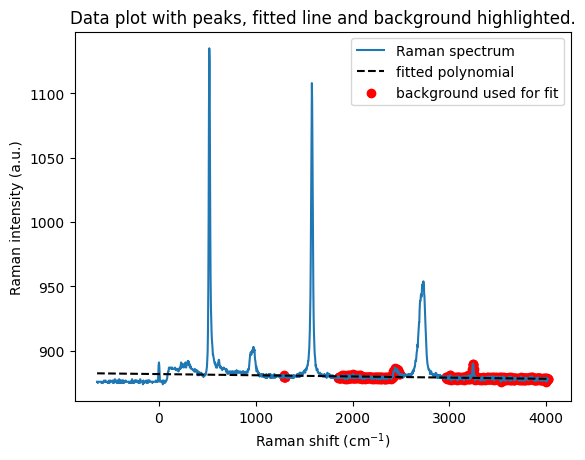

In [60]:
new_m, coeff, covar = m.remove_bg(fitmask = mask, toplot = True)

We can see that the previously used `mask` is also applied to the map.

In [220]:
m_nobg = m.remove_bg(height = 20, width = 50)

In [216]:
m_nobg = m.remove_bg(polyorder = 1, fitmask = mask)

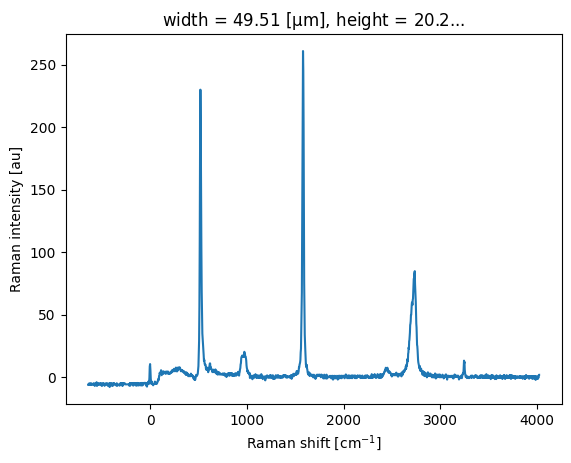

In [226]:
m_nobg.sel(height = 20, width = 50, method = 'nearest').plot()

## Normalizing spectra

### Single spectra

In [33]:
# Let's remove the background first
new_single_s, _, _ = single_s.remove_bg()

In [34]:
# Let's normalize to the G peak
new_single_s_norm = new_single_s.normalize(1580)

The normalized `xarray` is now unitless:

In [35]:
new_single_s_norm.ssxr.attrs['long_name'], new_single_s.ssxr.attrs['units']

('normalized Raman intensity', 'au')

In [36]:
print(new_single_s_norm.ssxr.attrs['comments'])

raw data loaded 
background subtracted, with parameters: {'polyorder': 1, 'hmin': 50, 'hmax': 10000, 'wmin': 4, 'wmax': 60, 'prom': 10, 'exclusion_factor': 6, 'peak_pos': None}
normalized to peak at: 1581.41



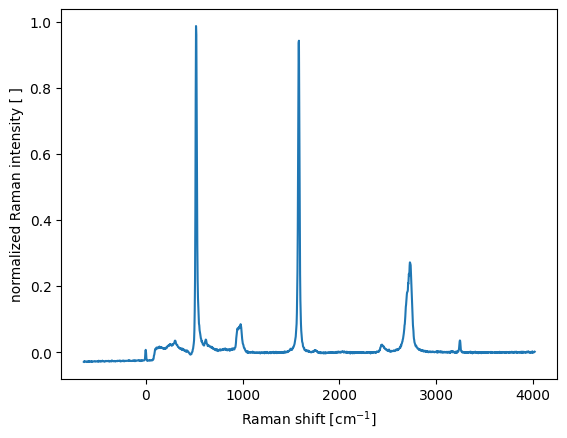

In [37]:
new_single_s_norm.ssxr.plot()

`singlespec.normalize()` can take any keyword argument which is used by `peakfit()`. For example, we can plot the fit that is used for normalization:

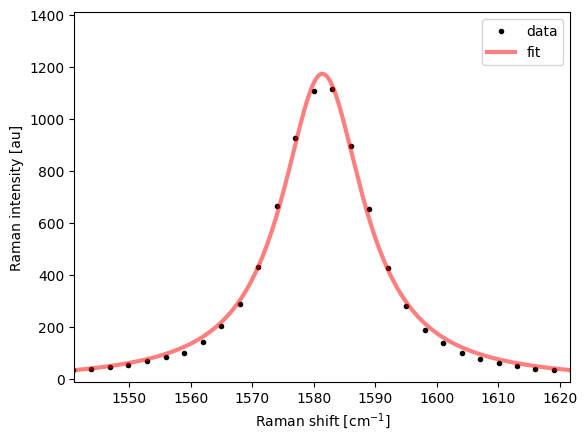

In [39]:
_ = new_single_s.normalize(1580, toplot = True)

### Maps

In [40]:
new_m, _, _ = m.remove_bg()

In [41]:
print(new_m.mapxr.attrs['comments'])

raw data loaded 
background subtracted - mode == const, background fit: middle spectrum 



In [54]:
new_m_norm = new_m.normalize(1580)

In [58]:
new_m_norm.history()

Data modification history:

raw data loaded 
background subtracted - mode == const, background fit: middle spectrum 
normalized to peak at: 1580.01 in mode == const



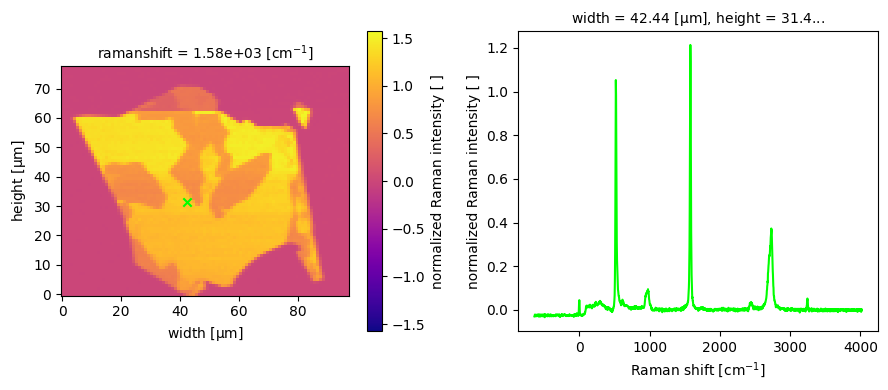

In [44]:
new_m_norm.plotspec(42, 31, 1580)

In [45]:
new_m_norm = new_m.normalize(1580, width = 20, height = 40)

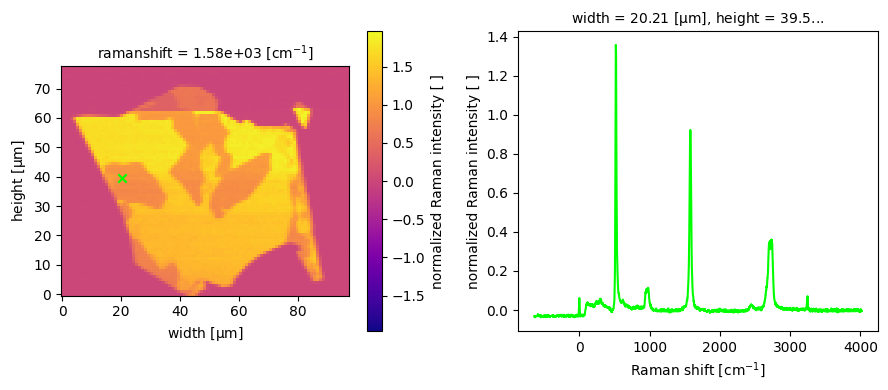

In [46]:
new_m_norm.plotspec(20, 40, 1580)

Let's try to normalize to each individual spectrum in the map.

In [47]:
new_m_norm = new_m.normalize(1580, mode = 'individual')

In [57]:
new_m_norm.history()

Data modification history:

raw data loaded 
background subtracted - mode == const, background fit: middle spectrum 
normalized to peak at: 1580.01 in mode == const



Now, we can see that the comments are appended, with another note, since we normalized an already normalized map.

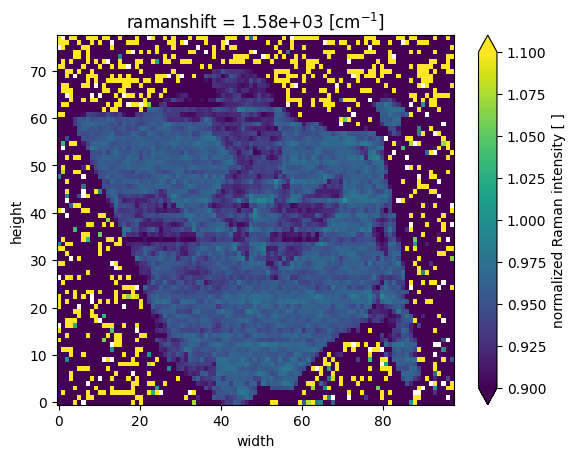

In [53]:
new_m_norm.mapxr.sel(ramanshift = 1580, method = 'nearest').plot(vmin = 0.9, vmax = 1.1)

## Curve fitting

One can either use the basic functionality of `curvefit` from the `scipy` package, which works on `numpy` arrays. However, `xarray` also has a built in functionality for curve fitting, where the end result is also an xarray object. This is just a wrapper around `scipy.optimize.curvefit`, so usage is similar.

### Let's try the curvefit within `xarray`.

In [9]:
ssfit = single_s.ssxr.curvefit(
    'ramanshift', rt.lorentz,
    p0 = {
        'x0': 1582,
        'ampl': 100,
        'width': 15,
        'offset': 0
    },
    bounds = {'width': [0, 100]}
)

In [17]:
# let's take a section of the map, to make fitting faster.
m_small = m.mapxr.sel(width = slice(30, 40), height = slice(20, 30))

Fitting to the map: `m_small`

In [18]:
mfit = m_small.curvefit(
    'ramanshift', rt.lorentz,
    p0 = {
        'x0': 1582,
        'ampl': 100,
        'width': 15,
        'offset': 0
    },
    bounds = {'width': [0, 100]}
)

Both of these fit results: `ssfit` and `mfit` are `xarray` Datasets, with the fit parameters of the fit function and the covariances.

`ramantools` has a built in `peakfit()` function which takes as the argument the `xarray` DataArray of a single spectrum or map. It has several options to tweak the fit, including starting values, bounds and an option to plot the resulting fit.

Let's try this for a single spectrum.

#### `peakfit()` within ramantools

With the default values for the start parameters, the `peakfit` method finds the G peak.
To fit a specific peak, the starting values can be adjusted, or the data can be sliced to the region around the peak in question.

Let's try to fit the 2D peak, by adjusting the starting values of the parameters.

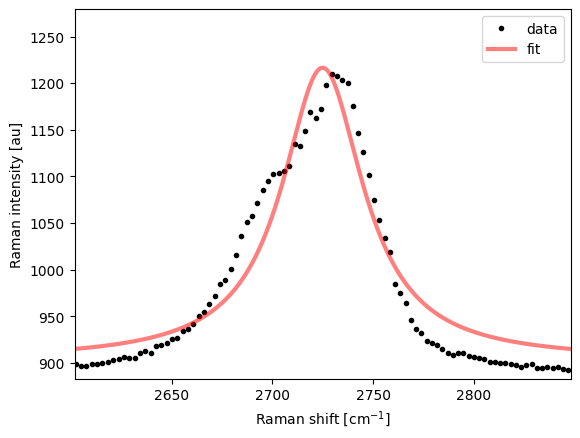

In [98]:
ssfit = rt.peakfit(single_s.ssxr, toplot = True, stval = {'x0': 2700, 'ampl': 100, 'width': 15, 'offset': 900})

Perfect. Let's see the values of the fit parameters:

In [68]:
ssfit['curvefit_coefficients']

<xarray.DataArray 'curvefit_coefficients' (param: 4)>
array([2724.93804474,  313.62330817,   49.23360899,  902.99289017])
Coordinates:
  * param    (param) <U6 'x0' 'ampl' 'width' 'offset'

In [92]:
print(ssfit.attrs['comments'])

raw data loaded 
peak fitting, using lorentz



We can use these parameters as the starting value of the next fit. We will fit the 2D peak of the entire map: `m.mapxr`. For this we need to build a dictionary of the Lorentz parameters and pass it to the `peakfit()` method.

In [78]:
# Let's subtract the background first
m_nobg, coeff, covar = m.remove_bg()

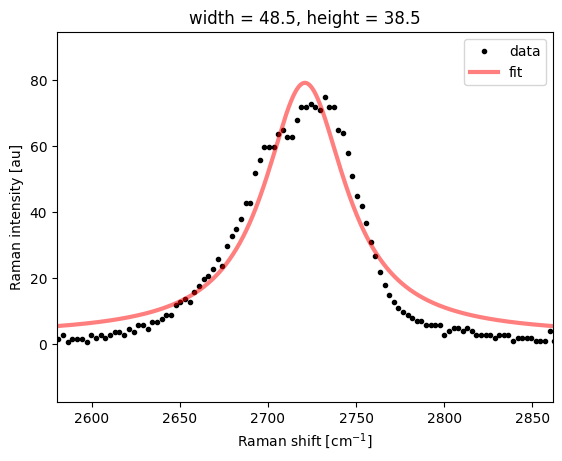

In [79]:
# Creating the dictionary
p = {'x0': 2724, 'ampl': 313, 'width': 49, 'offset': 0}
# passing the starting values contained in `p` to the `peakfit()` method. 
# Let's also add some boundaries for the parameters
b = {'x0': [2500, 2900], 'ampl': [0, 900], 'width': [20, 100], 'offset': [-10, 50]}
mapfit = rt.peakfit(m_nobg.mapxr, stval = p, bounds = None, toplot = True)

Let's look at the result, by plotting the width parameter of the fit Dataset.

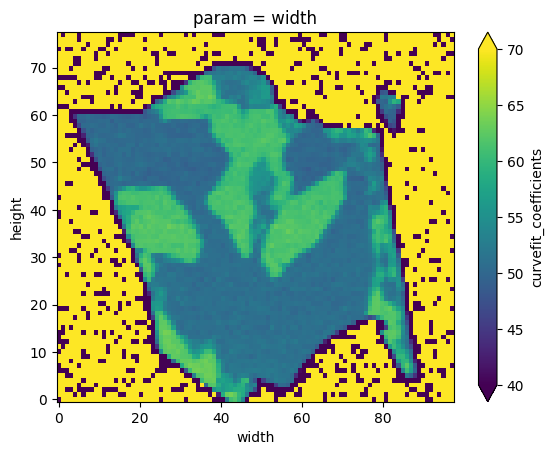

In [80]:
mapfit['curvefit_coefficients'].sel(param = 'width').plot(vmin = 40, vmax = 70)

In [81]:
print(mapfit.attrs['comments'])

raw data loaded 
background subtracted - mode == const, background fit: middle spectrum 
peak fitting, using lorentz



By passing a fit result (in this case `mapfit`) to the `peakfit()` function, we can skip the fitting and use it to plot the fit at other values of the `width` and `height` coordinates.

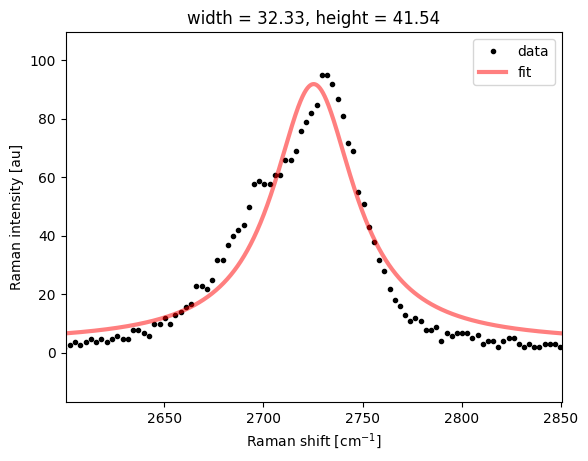

In [ ]:
_ = rt.peakfit(m_nobg.mapxr, fitresult = mapfit, toplot = True, width = 32, height = 42)

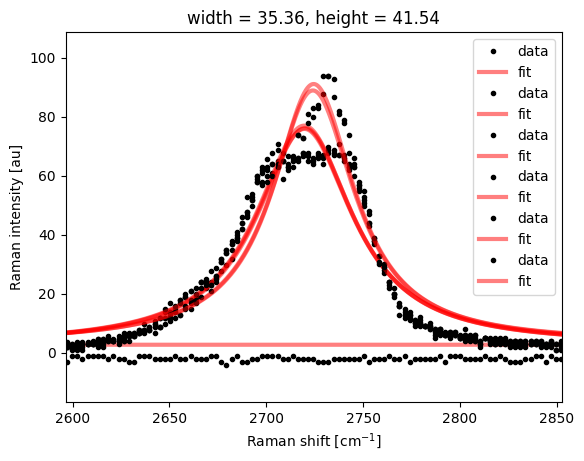

In [138]:
# plot the spectra and fits along height = 42, for widths from 10 to 40, every 5 microns
for w in np.arange(10, 40, 5):
    _ = rt.peakfit(m_nobg.mapxr, fitresult = mapfit, toplot = True, width = w, height = 42)
pl.legend(loc = 'upper right')

#### Drawmask
As used in Witec software

In [30]:
# create a boolean mask based on the intensity of the G peak.
gpeak = m.mapxr.sel(ramanshift = slice(1550, 1610))

Let's create a mean filter from this.

In [31]:
gmean = gpeak.mean(dim = 'ramanshift')

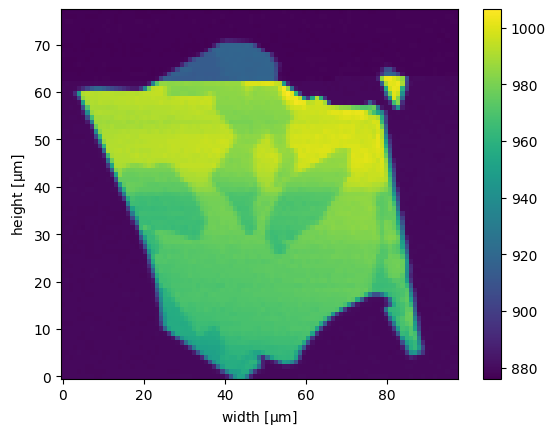

In [32]:
gmean.plot()

In [33]:
gmask = gmean > 900

In [42]:
gmask

<xarray.DataArray (height: 77, width: 97)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * width    (width) float64 0.0 1.01 2.021 3.031 ... 93.97 94.98 95.99 97.0
  * height   (height) float64 0.0 1.013 2.026 3.039 ... 73.96 74.97 75.99 77.0

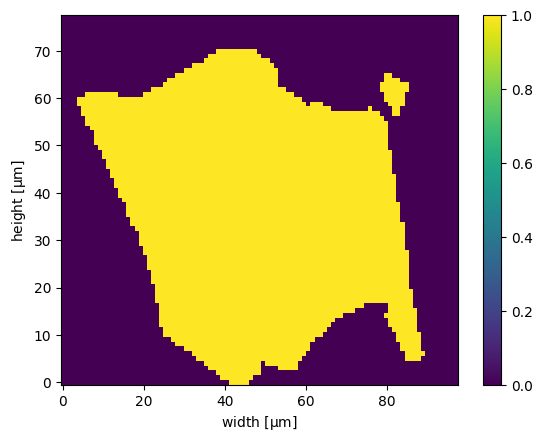

In [34]:
gmask.plot()

In [49]:
gfilter_map = m_nobg.mapxr.where(gmask)

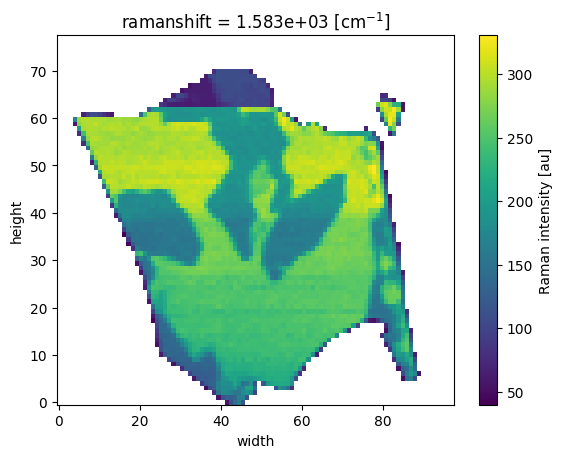

In [50]:
gfilter_map.sel(ramanshift = 1583, method = 'nearest').plot()

Let's calculate the area of the flake, by using this mask. We just need to count the number of `True` values in the mask.

In [51]:
# this is the area of a pixel
pixel_area = (m_nobg.size_x / m_nobg.pixel_x) * (m_nobg.size_y / m_nobg.pixel_y)
# to get the flake area we just need to sum the mask. This works because: True + True = 2 :)
flake_area = gmask.sum() * pixel_area
print('flake area is:', flake_area.data, 'um^2')

flake area is: 3748.0 um^2


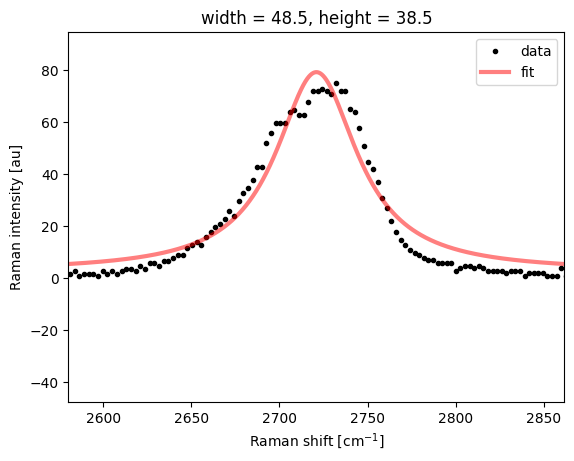

In [53]:
p = {'x0': 2724, 'ampl': 313, 'width': 49, 'offset': 900}
mapfit_gmask = rt.peakfit(gfilter_map, stval = p, toplot = True)

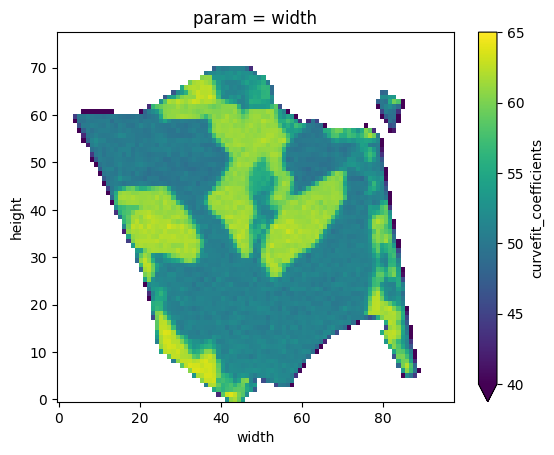

In [54]:
twodpeak_width = mapfit_gmask['curvefit_coefficients'].sel(param = 'width')
twodpeak_width.plot(vmin = 40, vmax = 65)

Let's calculate the area with wide 2D peaks.

In [55]:
# make another mask, based on the peak width
wide_twod_mask = twodpeak_width > 55
wide_twod = twodpeak_width.where(wide_twod_mask)

Let's highlight with red, the areas with a peak width > 55

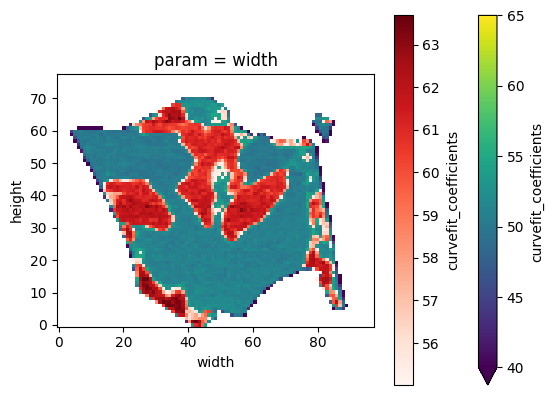

In [64]:
twodpeak_width.plot(cmap = 'viridis', vmin = 40, vmax = 65)
wide_twod.plot(cmap = 'Reds', alpha = 1)
ax = pl.gca()
ax.set_aspect(1)

In [68]:
wide_twod_area = wide_twod_mask.sum() * pixel_area
print('the area with a peak width > 55 is:', wide_twod_area.data, 'um^2')
print('This is ', str(100*wide_twod_area.data / flake_area.data)[:4], '% of the total flake area.')

the area with a peak width > 55 is: 1342.0 um^2
This is  35.8 % of the total flake area.


Let's remove the width and height dimensions, by placing them in a `pos` dimension. We can then drop the NaN values introduced by the mask in this. Finally, we can plot the peak width values on a histogram.

In [115]:
flake_flatten = twodpeak_width.stack(pos = ['width', 'height'])

In [116]:
flake_flatten = flake_flatten.dropna(dim = 'pos')

In [117]:
flake_flatten

<xarray.DataArray 'curvefit_coefficients' (pos: 3748)>
array([26.24816168, 44.50409976, 31.6729809 , ..., 38.69521998,
       34.42021117, 31.93883788])
Coordinates:
    param    <U6 'width'
  * pos      (pos) object MultiIndex
  * width    (pos) float64 4.042 4.042 5.052 5.052 ... 87.91 87.91 87.91 88.92
  * height   (pos) float64 58.76 59.78 56.74 57.75 ... 8.105 9.118 10.13 6.079

In [125]:
flake_wide_flatten = wide_twod.stack(pos = ['width', 'height'])
flake_wide_flatten = flake_wide_flatten.dropna(dim = 'pos')

Text(0.5, 0, 'peak width (cm$^{-1}$)')

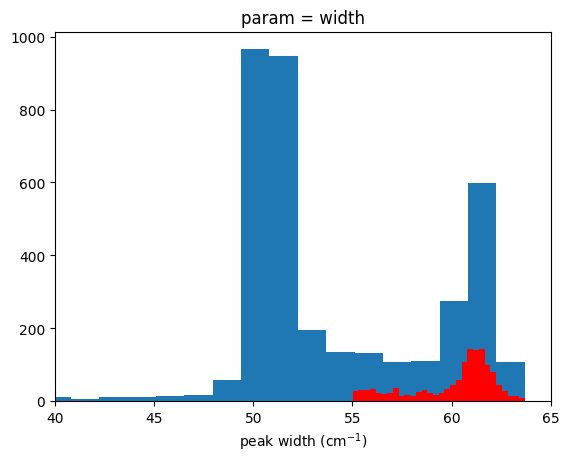

In [128]:
flake_flatten.plot.hist(bins = 60)
flake_wide_flatten.plot.hist(bins = 30, color = 'r')
pl.xlim([40, 65])
pl.xlabel('peak width (cm$^{-1}$)')

Let's try fitting a Gaussian.

c:\Users\zrbyt\WPy64-31090\python-3.10.9.amd64\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


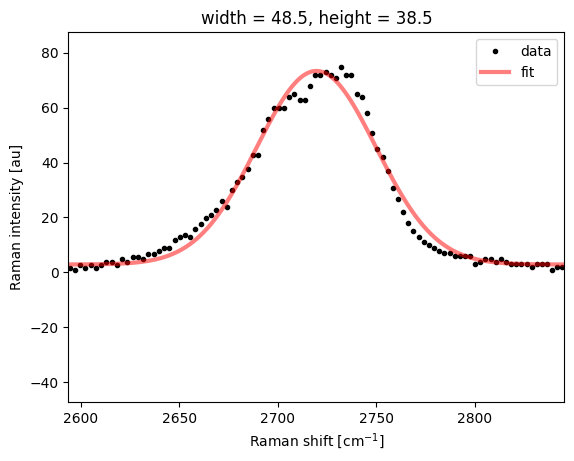

In [69]:
mfit_gauss = rt.peakfit(m_nobg.mapxr, func = rt.gaussian, stval = p, toplot = True)